# Filtering low-quality detections

See the text below and the word doc for more information about the filtering parameters

In [5]:
from os import path
import pandas as pd
import glob
import numpy as np
from IPython.display import display
from matplotlib import pyplot as plt
import napari
from skimage import io
import matplotlib.pyplot as plt
import seaborn as sns
import sys 
import zarr
import dask.array as da
import os 
sys.path.append('../src/')

from detections_preprocessing import hist_plot, box_whisker_plot, plot_histogram_cutoffs

plt.rcParams["font.family"] = ""

### Do not change the code in the cell below 

In [2]:
# This assumes that your notebook is inside 'Jupyter Notebooks', which is at the same level as 'test_data'
base_dir = os.path.join(os.path.dirname(os.path.abspath("__file__")), '..', 'movie_data')
# base_dir = os.path.join(os.path.dirname(os.path.abspath("__file__")), '..', 'test_movie_1')

zarr_directory = 'zarr_file/all_channels_data'
zarr_full_path = os.path.join(base_dir, zarr_directory)

input_directory = os.path.join(base_dir,'datasets')
# in the datasets directory, list pkl files that start with 'all_detections_channel'

files = glob.glob(f'{input_directory}/all_detections_channel*.pkl')

# take the first file
file = files[0]

input_directory_full = os.path.join(input_directory, file)

# find out which channel was detected
channel_detected = file.split('_channel')[-1].split('.')[0]

# input_file_name = 'all_detections_channel3.pkl'
# input_directory_full = os.path.join(base_dir,input_directory, input_file_name)

output_directory = 'datasets'
output_file_name = f'cleaned_spots_intensities_c{channel_detected}_all.pkl'
# output_file_name = 'cleaned_spots_intensities_c3_all.pkl'
output_directory_full = os.path.join(base_dir,output_directory, output_file_name)

In [3]:
spots_df = pd.read_pickle(input_directory_full)

z2 = zarr.open(zarr_full_path, mode='r')
z2.shape

(130, 3, 115, 2052, 340)

In [4]:
def calculate_whiskers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = Q1 - 1.5 * IQR
    upper_whisker = Q3 + 1.5 * IQR
    return lower_whisker, upper_whisker

# calculate the mean error (distance) of spot center and size, avg for xyz
# spots_df['mean_errors_mu'] = spots_df['errors'].apply(lambda x: pd.Series(x[1]).mean())
# spots_df['mean_errors_sigma'] = spots_df['errors'].apply(lambda x: pd.Series(x[2]).mean())

spots_df['mean_errors_mu'] = [np.mean(x[1]) for x in spots_df['errors']]
spots_df['mean_errors_sigma'] = [np.mean(x[2]) for x in spots_df['errors']]

# Assuming spots_df is your DataFrame
columns = ['amplitude', 'sigma_x', 'sigma_y', 'sigma_z', 'mean_errors_mu','mean_errors_sigma']
whiskers = {}

for col in columns:
    lower_whisker, upper_whisker = calculate_whiskers(spots_df[col])
    whiskers[col] = {'lower_whisker': lower_whisker, 'upper_whisker': upper_whisker}

amplitude_upper_limit = whiskers['amplitude']['upper_whisker']
sigmax_upper_limit = whiskers['sigma_x']['upper_whisker']
sigmay_upper_limit = whiskers['sigma_y']['upper_whisker']
sigmaz_upper_limit = whiskers['sigma_z']['upper_whisker']

# by default the lower limit for detection size is 0
sigmax_lower_limit = 0
sigmay_lower_limit = 0
sigmaz_lower_limit = 0

# uncomment the following three lines if you want to filter the detections with low detection size

# sigmax_lower_limit = whiskers['sigma_x']['lower_whisker']
# sigmay_lower_limit = whiskers['sigma_y']['lower_whisker']
# sigmaz_lower_limit = whiskers['sigma_z']['lower_whisker']

mean_errors_mu_upper_limit = whiskers['mean_errors_mu']['upper_whisker']
mean_errors_sigma_upper_limit = whiskers['mean_errors_sigma']['upper_whisker']

## Adjust these tolerance parameters to adjust how strict the detection filtering is 
Below 1 = more strict.

If you see clear breaks in the histogram, you can adjust the tolerance values such that the red dotted line separates (filters out) some of the outliers.

It's better to err toward including more spots at this stage and filter out tracks in later notebooks.

the upper limit for amplitude is 883.62
the upper limit for sigma x  is 10.0
the upper limit for sigma y is 17.5
the upper limit for sigma z is 16.5
the upper limit for mean error mu is 2.28
the upper limit for mean error sigma is 6.43


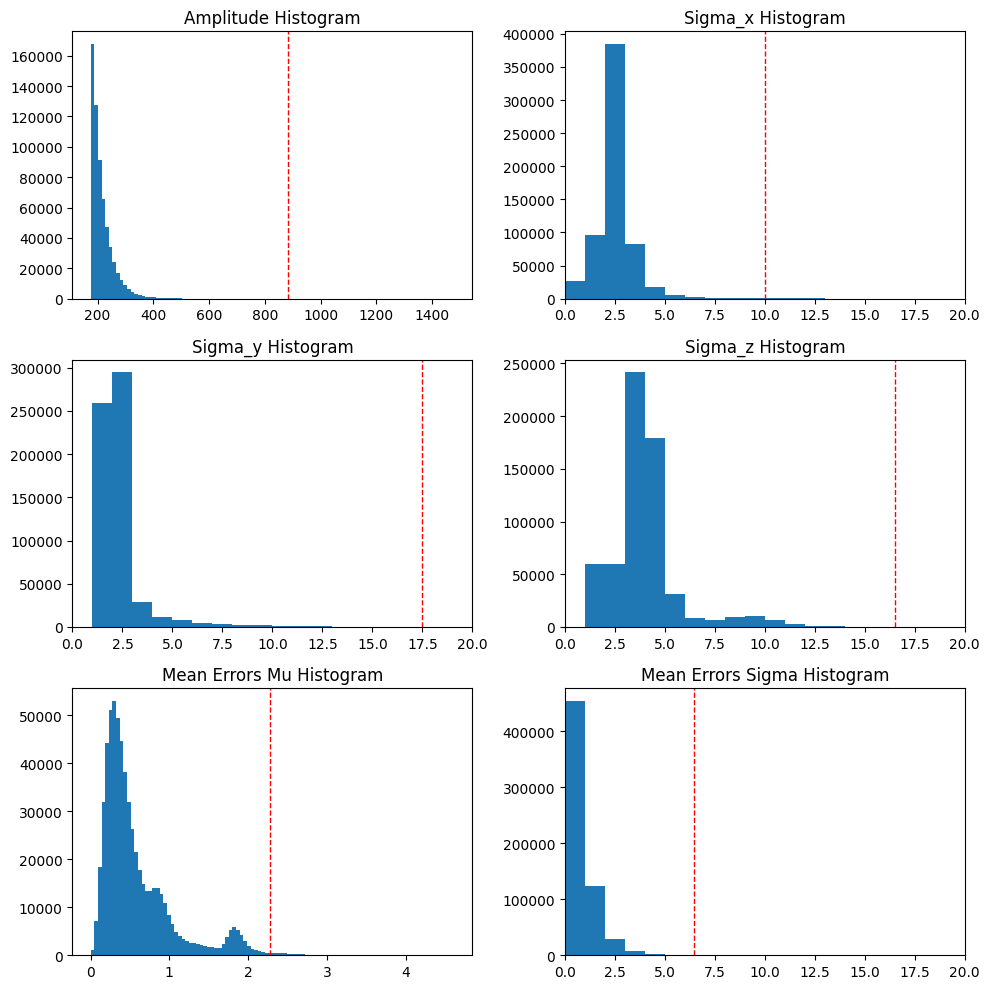

In [18]:
############################################
# remove bright detections
amplitude_tolerance = 3

# remove large detections
sigmax_tolerance = 5.0
sigmay_tolerance = 5.0
sigmaz_tolerance = 3.0

# remove low detection quality (high error) detections
quality_threshold_mu = 1.6
quality_threshold_sigma = 3.0
############################################

print(f'the upper limit for amplitude is {round(amplitude_upper_limit*amplitude_tolerance,2)}')
print(f'the upper limit for sigma x  is {round(sigmax_upper_limit*sigmax_tolerance,2)}')
print(f'the upper limit for sigma y is {round(sigmay_upper_limit*sigmay_tolerance,2)}')
print(f'the upper limit for sigma z is {round(sigmaz_upper_limit*sigmaz_tolerance,2)}')
print(f'the upper limit for mean error mu is {round(mean_errors_mu_upper_limit*quality_threshold_mu,2)}')
print(f'the upper limit for mean error sigma is {round(mean_errors_sigma_upper_limit*quality_threshold_sigma,2)}')

amplitude_cutoff = amplitude_upper_limit * amplitude_tolerance 
sigmax_cutoff = sigmax_upper_limit * sigmax_tolerance
sigmay_cutoff = sigmay_upper_limit * sigmay_tolerance
sigmaz_cutoff = sigmaz_upper_limit * sigmaz_tolerance
mu_upper_cutoff = mean_errors_mu_upper_limit * quality_threshold_mu
sigma_upper_cutoff = mean_errors_sigma_upper_limit * quality_threshold_sigma

plot_histogram_cutoffs(spots_df,amplitude_cutoff,sigmax_cutoff,sigmay_cutoff,sigmaz_cutoff,mu_upper_cutoff,sigma_upper_cutoff)

In [19]:
# Condition setting

# don't change anything in this cell
#dropping spots above certain threshold 
condition_1 = spots_df['amplitude'] <= amplitude_upper_limit * amplitude_tolerance 

#dropping spots above certain standard dev in x
condition_2 = spots_df['sigma_x'] <= sigmax_upper_limit * sigmax_tolerance


#dropping spots above certain standard dev in y 
condition_3 = spots_df['sigma_y'] <= sigmay_upper_limit * sigmay_tolerance


#dropping spots above certain standard dev in z
condition_4 = spots_df['sigma_z'] <= sigmaz_upper_limit * sigmaz_tolerance


## No need to change the below conditions 

#dropping spots below certain standard dev in x
condition_5 = spots_df['sigma_x'] >= sigmax_lower_limit

#dropping spots below certain standard dev in y
condition_6 = spots_df['sigma_y'] >= sigmay_lower_limit

#dropping spots below certain standard dev in z
condition_7 = spots_df['sigma_z'] >= sigmaz_lower_limit

#dropping spots out of bounds of z axis 
condition_8 = spots_df['mu_z'] >= 0
condition_9 = spots_df['mu_z'] <= z2.shape[2]

#dropping spots out of bounds of x axis 
condition_10 = spots_df['mu_x'] >= 0
condition_11 = spots_df['mu_x'] <= z2.shape[4]

#dropping spots out of bounds of y axis 
condition_12 = spots_df['mu_y'] >= 0
condition_13 = spots_df['mu_y'] <= z2.shape[3]

condition_14 = spots_df['mean_errors_mu'] <= mean_errors_mu_upper_limit * quality_threshold_mu
condition_15 = spots_df['mean_errors_sigma'] <= mean_errors_sigma_upper_limit * quality_threshold_sigma

# Combine the conditions using logical AND (&)
cleaned_spots_df = spots_df[condition_1 & condition_2 & condition_3 & condition_4 & condition_5 & condition_6 &
condition_7 & condition_8 & condition_9 & condition_10 & condition_11 & condition_11 & condition_12 & condition_13 & condition_14 & condition_15].reset_index(drop = True)

dropped_spots = spots_df[~(condition_1 & condition_2 & condition_3 & condition_4 & condition_5 & condition_6 &
condition_7 & condition_8 & condition_9 & condition_10 & condition_11 & condition_11 & condition_12 & condition_13 & condition_14 & condition_15)]


In [20]:
# Save the DataFrame to a Pickle file
cleaned_spots_df.to_pickle(output_directory_full)

In [ ]:
output_directory_full

## VISUALISATION

Use this viewer to visually assess whether the detections correspond to the spots you see, and if the dropped detections correspond to noise.

Adjust the thresholds accordingly based on guidelines below.
In this notebook you can only drop points not add points, so if you think spots have been missed during detection, go back to notebook 01. 

In [21]:
# Create a napari viewer
viewer = napari.Viewer()

#access channel 3 only from zarr array 
dask_array = da.from_zarr(z2)

#the axis arrangement is (t,c,z,y,x)
# all_channels = dask_array[:,:,:,:,:]

# Import detection channel
detection_channel = dask_array[:, int(channel_detected)-1,:,:,:]


# Add the 4D stack to the viewer
# layer_raw = viewer.add_image(all_channels, channel_axis = 1, name = ['Channel 1', 'Channel 2', 'Channel 3'])
# layer_raw = viewer.add_image(all_channels, channel_axis = 1, name = ['channel 1', 'channel 2', 'channel 3'], interpolation3d = 'nearest', blending = 'additive', colormap = 'gray_r', visible = [False, False, True])

layer_raw = viewer.add_image(detection_channel, name = 'fluorescence', interpolation3d = 'nearest', blending = 'additive', colormap = 'gray_r', visible = True)

#other useful parameters 
#color_map = list
#contrast_limits = list of list 

# Add Bounding Box
layer_raw.bounding_box.visible = True
# layer_raw[0].bounding_box.visible = True
# layer_raw[1].bounding_box.visible = True
# layer_raw[2].bounding_box.visible = True

#Visualising all dropped spots and the cleaned spots 
points_layer = viewer.add_points(cleaned_spots_df[["frame", "mu_z", "mu_y", "mu_x"]], size=3, 
                                name = 'Cleaned Spots', face_color = 'lime', symbol = 'ring')


points_layer = viewer.add_points(spots_df[~condition_1][["frame", "mu_z", "mu_y", "mu_x"]], size=3, 
                                name = 'High amplitude', face_color = '#aa0000', symbol = 'ring')

points_layer = viewer.add_points(spots_df[~condition_2][["frame", "mu_z", "mu_y", "mu_x"]], size=3,
                                name = 'High sigma x', face_color = '#ff0000', symbol = 'ring')

points_layer = viewer.add_points(spots_df[~condition_3][["frame", "mu_z", "mu_y", "mu_x"]], size=3,
                                name = 'High sigma y', face_color = '#ff0000', symbol = 'ring')

points_layer = viewer.add_points(spots_df[~condition_4][["frame", "mu_z", "mu_y", "mu_x"]], size=3,
                                name = 'High sigma z', face_color = '#ff0000', symbol = 'ring')

points_layer = viewer.add_points(spots_df[~condition_5][["frame", "mu_z", "mu_y", "mu_x"]], size=3,
                                name = 'Low sigma x', face_color = '#ff00ff', symbol = 'ring')

points_layer = viewer.add_points(spots_df[~condition_6][["frame", "mu_z", "mu_y", "mu_x"]], size=3,
                                name = 'Low sigma y', face_color = '#ff00ff', symbol = 'ring')

points_layer = viewer.add_points(spots_df[~condition_7][["frame", "mu_z", "mu_y", "mu_x"]], size=3,
                                name = 'Low sigma z', face_color = '#ff00ff', symbol = 'ring')

points_layer = viewer.add_points(spots_df[~condition_8&condition_9&condition_10&condition_12&condition_13][["frame", "mu_z", "mu_y", "mu_x"]], size=3,
                                name = 'Out of bounds', face_color = '#aa007f', symbol = 'ring')

points_layer = viewer.add_points(spots_df[~condition_14][["frame", "mu_z", "mu_y", "mu_x"]], size=3,
                                name = 'High mean error mu', face_color = '#ff557f', symbol = 'ring')

points_layer = viewer.add_points(spots_df[~condition_15][["frame", "mu_z", "mu_y", "mu_x"]], size=3,
                                name = 'High mean error sigma', face_color = '#ff557f', symbol = 'ring')

# points_layer = viewer.add_points(dropped_spots[["frame", "mu_z", "mu_y", "mu_x"]], size=3, 
#                                 name = 'Dropped Spots', face_color = 'blue', symbol = 'ring')

# points_layer = viewer.add_points(spots_df[["frame", "mu_z", "mu_y", "mu_x"]], size=3, 
#                                 name = 'All Spots', face_color = 'white', symbol = 'ring')

## The goal is for the green spots to circle true spots, and the red-ish spots to circle noise

* Toggle each red circle one at a time and assess if it captures noise. If it is capturing real spots, then increase the tolerance for that feature and re run the condition setting and visualization cells.

* Look at the green circles. If the green circles are capturing noise, then increase the tolerance for a feature and see if it changes. 

* You can also use the histograms below to guide your choice: look for breaks between two distributions, or long tails

* Repeat until you're satisfied with the quality of your detections!
